# Task 2

## Install Openspiel

In [1]:
!pip install --upgrade open_spiel

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.8/4.8 MB 7.1 MB/s eta 0:00:00


## Test install

In [2]:
import numpy as np
from numpy.ma.extras import row_stack
import pyspiel
import matplotlib.pyplot as plt
from open_spiel.python.egt import dynamics
from open_spiel.python.egt import visualization
from open_spiel.python.egt.utils import game_payoffs_array
print(pyspiel.registered_names())

['2048', 'amazons', 'backgammon', 'bargaining', 'battleship', 'blackjack', 'blotto', 'breakthrough', 'bridge', 'bridge_uncontested_bidding', 'catch', 'checkers', 'chess', 'cliff_walking', 'clobber', 'coin_game', 'colored_trails', 'connect_four', 'coop_box_pushing', 'coop_to_1p', 'coordinated_mp', 'cursor_go', 'dark_chess', 'dark_hex', 'dark_hex_ir', 'deep_sea', 'efg_game', 'euchre', 'first_sealed_auction', 'gin_rummy', 'go', 'goofspiel', 'hanabi', 'havannah', 'hearts', 'hex', 'kriegspiel', 'kuhn_poker', 'laser_tag', 'leduc_poker', 'lewis_signaling', 'liars_dice', 'liars_dice_ir', 'mancala', 'markov_soccer', 'matching_pennies_3p', 'matrix_cd', 'matrix_coordination', 'matrix_mp', 'matrix_pd', 'matrix_rps', 'matrix_rpsw', 'matrix_sh', 'matrix_shapleys_game', 'mfg_crowd_modelling', 'mfg_crowd_modelling_2d', 'mfg_dynamic_routing', 'mfg_garnet', 'misere', 'morpion_solitaire', 'negotiation', 'nfg_game', 'nim', 'normal_form_extensive_game', 'oh_hell', 'oshi_zumo', 'othello', 'oware', 'pathfind

## Algorithms

### Epsilon-Greedy & Lenient-Boltzman

Now, we define the algorithms for epsilon greedy and lenient Boltzmann q-learning.

In [3]:
import numpy as np
import matplotlib.pyplot as plt

# Define the parameters for ε-greedy and Lenient Boltzmann Q-learning
epsilon = 0.1
temperature = 0.9
leniency = 0.1
decay = 0.1
min_temp = 0.01


def epsilon_greedy(Q, player, num_actions):
    if np.random.uniform(0, 1) < epsilon:
        # Choose a random action
        a = np.random.randint(0, num_actions)
    else:
        # Choose the action with the highest Q-value
        a = np.argmax(Q[player])
    return a


def lenient_boltzmann(Q, player, temp, num_actions):
    # Compute the lenient probabilities for each action
    lenient_probs = np.exp(Q[player] / temp)
    lenient_probs = lenient_probs / np.sum(lenient_probs)

    # Compute the strict probabilities for each action
    max_q = np.max(Q[player])
    strict_probs = np.zeros(num_actions)
    strict_probs[np.where(Q[player] == max_q)] = 1 / np.sum(Q[player] == max_q)

    # Combine the lenient and strict probabilities using the leniency factor
    probs = leniency * lenient_probs + (1 - leniency) * strict_probs

    # Choose an action according to the probabilities
    a = np.random.choice(num_actions, p=probs)

    temperature = max(min_temp, decay * temp)

    return a

### Openspiel dynamics with lenient Boltzmann Q-learning

We also define the the algorithm to compute the dynamics with lenient Boltzmann q-learning. The algorithm makes use of the Openspiel implementation to compute the dynamics with Boltzmann q-learning. This algorithm makes use formula 10 from the paper 'Evolutionary Dynamics of Multi-Agent Learning: A Survey'. We adapted this algorithm such that it also uses formula 11 of the paper to include the lenient part of the algorithm. It keeps track of k previous rewards and uses these to update the Q-values.

In [41]:
def lenient_boltzmann_dyn(state, fitness, temp=0.1):
  """
  Args:
    state: vector representing the probability distribution over the available actions for the agent in the given state.
    fitness: vector representing the expected reward for each action in the current state.
    temp: scalar parameter determining the rate of exploration.
  Returns:
    Time derivative of the population state.
  """
  avg_fitness = state.dot(fitness)
  exploitation = (1. / temp) * state * (fitness - avg_fitness)
  exploration = (np.log(state) - state.dot(np.log(state).transpose()))
  return exploitation - state * exploration


def boltzmann_probabilities(fitness, temp=0.1):
    """
    Args:
        fitness: vector representing the expected reward for each action in the current state.
        temp: scalar parameter determining the rate of exploration.
    Returns:
        Vector of Boltzmann probabilities for each action.
    """
    exp_fitness = np.exp(fitness / temp)
    return exp_fitness / np.sum(exp_fitness)


class LenientBoltzmannMultiQDynamics:
    def __init__(self, payoff_tensor, dynamics, k):
        dynamics = [dynamics] * payoff_tensor.shape[0]
        self.payoff_tensor = payoff_tensor
        self.dynamics = dynamics
        self.k = k # minimum number of times an action should be executed before its maximal reward is used for update.
        self.history = {}

    def __call__(self, state=None, time=None):
        n = self.payoff_tensor.shape[0]  # number of players
        ks = self.payoff_tensor.shape[1:]  # number of strategies for each player
        assert state.shape[0] == sum(ks)

        states = np.split(state, np.cumsum(ks)[:-1])
        dstates = [None] * n
        for i in range(n):
            # move i-th population to front
            fitness = np.moveaxis(self.payoff_tensor[i], i, 0)
            # marginalize out all other populations
            for i_ in set(range(n)) - {i}:
                fitness = np.tensordot(states[i_], fitness, axes=[0, 1])

            # Keep track of the last k values for state and fitness for each action
            for j, s in enumerate(states[i]):
                key = (i, j)
                if key not in self.history:
                    self.history[key] = {'state': [], 'fitness': []}
                if len(self.history[key]['state']) >= self.k:
                    self.history[key]['state'].pop(0)
                    self.history[key]['fitness'].pop(0)
                self.history[key]['state'].append(s)
                self.history[key]['fitness'].append(fitness[j])
            u = [0,0]
            for j in range(2):
                if len(self.history[(i,j)]['state']) == self.k:
                    sum1 = 0
                    sum2 = 0
                    sum3 = 0
                    for z in range(self.k):
                        if self.history[(i,j)]['state'][z] <= states[i][j]:
                            sum1 += self.history[(i,j)]['fitness'][z]
                        if self.history[(i,j)]['state'][z] < states[i][j]:
                            sum2 += self.history[(i,j)]['fitness'][z]
                        if self.history[(i,j)]['state'][z] == states[i][j]:
                            sum3 += self.history[(i,j)]['fitness'][z]
                    sum1 = sum1**self.k
                    sum2 = sum2**self.k
                    u[j] = fitness[j] * (sum1 - sum2) / sum3

            dstates[i] = self.dynamics[i](states[i], u)
                
        return np.concatenate(dstates)


class LenientBoltzmannSingleQDynamics:
    def __init__(self, payoff_tensor, dynamics, k):
        self.payoff_tensor = payoff_tensor[0]
        self.dynamics = dynamics
        self.k = k # minimum number of times an action should be executed before its maximal reward is used for update.
        self.history = {}

    def get_fitness(self, state):
        # Return the fitness by taking the matrix product between the state and the payoff_matrix
        fitness = np.matmul(state, self.payoff_tensor.T)
        return fitness

    def __call__(self, state=None, time=None):
        fitness = self.get_fitness(state)

        # Keep track of the last k values for state and fitness for each action
        for j, s in enumerate(state):
            key = j
            if key not in self.history:
                self.history[key] = {'state': [], 'fitness': []}
            if len(self.history[key]['state']) >= self.k:
                self.history[key]['state'].pop(0)
                self.history[key]['fitness'].pop(0)
            self.history[key]['state'].append(s)
            self.history[key]['fitness'].append(fitness[j])
        u = [0,0,0]
        for j in range(3):
            if len(self.history[j]['state']) == self.k:
                sum1 = 0
                sum2 = 0
                sum3 = 0
                for z in range(self.k):
                    if self.history[j]['state'][z] <= state[j]:
                        sum1 += self.history[j]['fitness'][z]
                    if self.history[j]['state'][z] < state[j]:
                        sum2 += self.history[j]['fitness'][z]
                    if self.history[j]['state'][z] == state[j]:
                        sum3 += self.history[j]['fitness'][z]
                sum1 = sum1**self.k
                sum2 = sum2**self.k
                u[j] = fitness[j] * (sum1 - sum2) / sum3

        return self.dynamics(state, u)

## Play Game

Now, we define a function to play a benchmark game. The function takes the payoff matrix of the game and q-table. The game is then played for the specified number of episodes with epsilon-greedy or lenient Boltzmann q-learning. 

In [71]:
def play_game(game, q_table, num_actions, num_players, num_episodes, alpha, greedy, RPS):
    if RPS:
        # Initialize empty lists to store change of the policy for each action of player 1
        rock = []
        paper = []
        scissors = []
    else:
        # Initialize empty lists to store the change of the policy for each player
        player1_policy = []
        player2_policy = []

    temperature = 0.9

    # play multiple episodes of the game
    for i in range(num_episodes):
        # Choose actions for both players using epsilon-greedy or lenient_boltzmann algorithm
        if greedy:
            p1_action = epsilon_greedy(Q_table, 0, num_actions)
            p2_action = epsilon_greedy(Q_table, 1, num_actions)
        else:
            p1_action = lenient_boltzmann(Q_table, 0, temperature, num_actions)
            p2_action = lenient_boltzmann(Q_table, 1, temperature, num_actions)

        # Determine rewards obtained by both players in the current episode
        p1_reward = game[0][p1_action][p2_action]
        p2_reward = game[1][p1_action][p2_action]

        # Update Q-values using the reinforcement learning rule
        Q_table[0][p1_action] += alpha * (p1_reward - Q_table[0][p1_action])
        Q_table[1][p2_action] += alpha * (p2_reward - Q_table[1][p2_action])

        # Calculate the softmax probability distribution for each player
        p1_probs = np.exp(Q_table[0]) / np.sum(np.exp(Q_table[0]))
        p2_probs = np.exp(Q_table[1]) / np.sum(np.exp(Q_table[1]))
        
        if RPS:
            # Append probability of player 1 to select each action
            rock.append(p1_probs[0])
            paper.append(p1_probs[1])
            scissors.append(p1_probs[2])
        else:
            # Append probability of each player to select action 1
            player1_policy.append(p1_probs[0])
            player2_policy.append(p2_probs[0])
        
    if RPS:
        return Q_table, rock, paper, scissors
    else:
        return Q_table, player1_policy, player2_policy

# Define a function to initialize Q_table with random numbers
def initialize_Q_table(num_actions, num_players, game):
    # Get the possible values that can be retrieved from the game matrix
    max_reward = np.amax(game[0])
    min_reward = np.amin(game[0])

    # Initialize Q-values for each action with random numbers between min_reward and max_reward
    Q_table = np.random.uniform(low=min_reward, high=max_reward, size=(num_players, num_actions))

    return Q_table

### Plot Learning Trajectory

This are helper functions to plot the learning trajectories of the games.

In [7]:
def trajectory_plot(ax, player1_policy, player2_policy):
    ax.plot(player1_policy, player2_policy)

def trajectory_plot_RPS(ax, rock, paper, scissors):
    zipped = [list(t) for t in zip(rock, paper, scissors)]
    ax.plot(zipped)

## Benchmark games

Now, we will play the different benchmark games with epsilon greedy and Lenient Boltzmann Q-learning and plot the learning trajectories together with the directional field plot.

### Prisoners Dilemma: Epsilon greedy

Learned Q-values:
[[-3.82222866 -2.60833344]
 [-3.88554389 -2.49315642]]


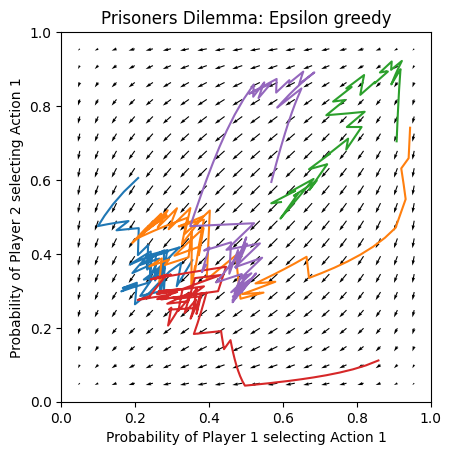

In [ ]:
# Define the Prisoner's Dilemma game
payoff_matrix = np.array([[[-1, -4],
                     [0, -3]],
                     [[-1, 0],
                      [-4, -3]]])

# Set up the replicator dynamics
dyn = dynamics.MultiPopulationDynamics(payoff_matrix, dynamics.replicator)

# Create an object of the Dynamics2x2Axes class
fig, ax = plt.subplots(subplot_kw={'projection': visualization.Dynamics2x2Axes.name})
ax.set_xlabel('Probability of Player 1 selecting Action 1')
ax.set_ylabel('Probability of Player 2 selecting Action 1')
ax.set_title('Prisoners Dilemma: Epsilon greedy')

# Plot the directional field plot
ax.quiver(dyn, 20)

# Perform q-learning with epsilon greedy
Q_table = np.zeros((2, 2))
q_table, player1_policy, player2_policy = play_game(payoff_matrix, Q_table, 2, 2, 1000, 0.1, True, False)

print("Learned Q-values:")
print(q_table)

# Overlay multiple learning trajectories on the directional field plot
for i in range(5):
  Q_table = initialize_Q_table(2, 2, payoff_matrix)
  q_table, player1_policy, player2_policy = play_game(payoff_matrix, Q_table, 2, 2, 200, 0.1, True, False)
  trajectory_plot(ax, player1_policy, player2_policy)

### Prisoners Dileamma: Lenient Boltzmann

Learned Q-values:
[[-3.54214262 -2.9990845 ]
 [-3.14053013 -2.93672198]]


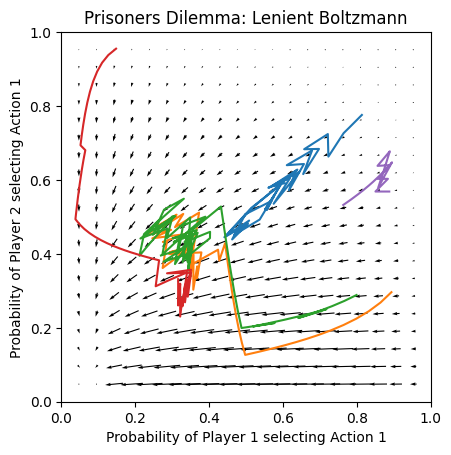

In [31]:
# Define the Prisoner's Dilemma game
payoff_matrix = np.array([[[-1, -4],
                     [0, -3]],
                     [[-1, 0],
                      [-4, -3]]])

# Set up the replicator dynamics
dyn = LenientBoltzmannMultiQDynamics(payoff_matrix, lenient_boltzmann_dyn, 3)

# Create an object of the Dynamics2x2Axes class
fig, ax = plt.subplots(subplot_kw={'projection': visualization.Dynamics2x2Axes.name})
ax.set_xlabel('Probability of Player 1 selecting Action 1')
ax.set_ylabel('Probability of Player 2 selecting Action 1')
ax.set_title('Prisoners Dilemma: Lenient Boltzmann')

# Plot the directional field plot
ax.quiver(dyn, 20)

# Perform q-learning with epsilon greedy
Q_table = np.zeros((2, 2))
q_table, player1_policy, player2_policy = play_game(payoff_matrix, Q_table, 2, 2, 1000, 0.1, False, False)

print("Learned Q-values:")
print(q_table)

# Overlay multiple learning trajectories on the directional field plot
for i in range(5):
  Q_table = initialize_Q_table(2, 2, payoff_matrix)
  q_table, player1_policy, player2_policy = play_game(payoff_matrix, Q_table, 2, 2, 200, 0.1, False, False)
  trajectory_plot(ax, player1_policy, player2_policy)

## Battle of the Sexes: epsilon greedy

Learned Q-values:
[[2.76935628 0.0367204 ]
 [1.89295903 0.05383217]]


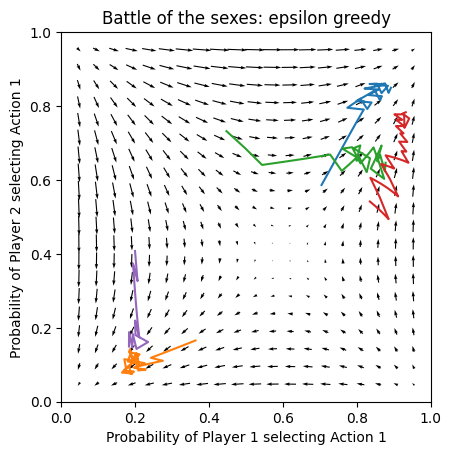

In [ ]:
# Define the Battle of the Sexes game
payoff_matrix = np.array([[[3, 0],
                     [0, 2]],
                     [[2, 0],
                      [0, 3]]])

# Set up the replicator dynamics
dyn = dynamics.MultiPopulationDynamics(payoff_matrix, dynamics.replicator)

# Create an object of the Dynamics2x2Axes class
fig, ax = plt.subplots(subplot_kw={'projection': visualization.Dynamics2x2Axes.name})
ax.set_xlabel('Probability of Player 1 selecting Action 1')
ax.set_ylabel('Probability of Player 2 selecting Action 1')
ax.set_title('Battle of the sexes: epsilon greedy')

# Plot the directional field plot
ax.quiver(dyn, 20)

# Perform q-learning with epsilon greedy
Q_table = np.zeros((2, 2))
q_table, player1_policy, player2_policy = play_game(payoff_matrix, Q_table, 2, 2, 1000, 0.01, True, False)

print("Learned Q-values:")
print(q_table)

# Overlay multiple learning trajectories on the directional field plot
for i in range(5):
  Q_table = initialize_Q_table(2, 2, payoff_matrix)
  q_table, player1_policy, player2_policy = play_game(payoff_matrix, Q_table, 2, 2, 100, 0.1, True, False)
  trajectory_plot(ax, player1_policy, player2_policy)

## Battle of the Sexes: Lenient Boltzmann

Learned Q-values:
[[2.99986517 0.        ]
 [1.99991009 0.        ]]


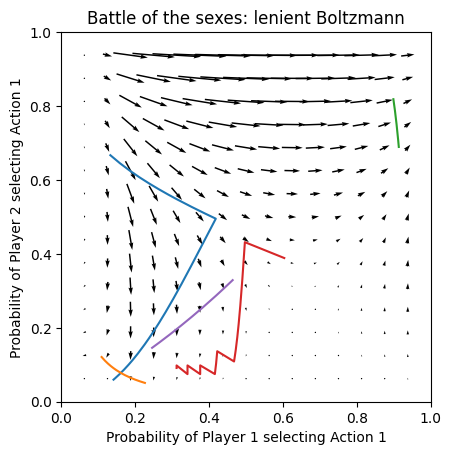

In [70]:
# Define the Battle of the Sexes game
payoff_matrix = np.array([[[3, 0],
                     [0, 2]],
                     [[2, 0],
                      [0, 3]]])

# Set up the replicator dynamics
dyn = LenientBoltzmannMultiQDynamics(payoff_matrix, lenient_boltzmann_dyn, 3)

# Create an object of the Dynamics2x2Axes class
fig, ax = plt.subplots(subplot_kw={'projection': visualization.Dynamics2x2Axes.name})
ax.set_xlabel('Probability of Player 1 selecting Action 1')
ax.set_ylabel('Probability of Player 2 selecting Action 1')
ax.set_title('Battle of the sexes: lenient Boltzmann')

# Plot the directional field plot
ax.quiver(dyn, 15)

# Perform q-learning with epsilon greedy
Q_table = np.zeros((2, 2))
q_table, player1_policy, player2_policy = play_game(payoff_matrix, Q_table, 2, 2, 1000, 0.01, False, False)

print("Learned Q-values:")
print(q_table)

# Overlay multiple learning trajectories on the directional field plot
for i in range(5):
  Q_table = initialize_Q_table(2, 2, payoff_matrix)
  q_table, player1_policy, player2_policy = play_game(payoff_matrix, Q_table, 2, 2, 200, 0.1, False, False)
  trajectory_plot(ax, player1_policy, player2_policy)

## Dispersion: Epsilon greedy

Learned Q-values:
[[-0.39398781  0.9270099 ]
 [ 0.89774025 -0.33935264]]


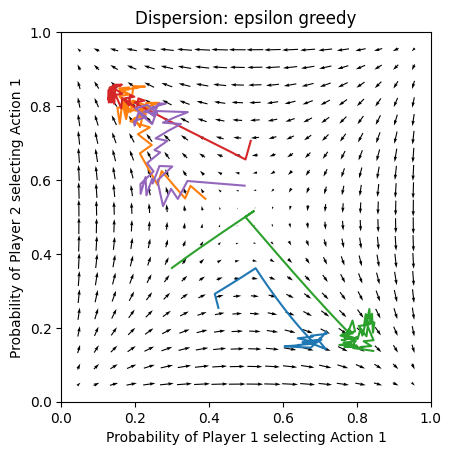

In [66]:
# Define the Dispersion game
payoff_matrix = np.array([[[-1, 1],
                     [1, -1]],
                     [[-1, 1],
                      [1, -1]]])

# Set up the replicator dynamics
dyn = dynamics.MultiPopulationDynamics(payoff_matrix, dynamics.replicator)

# Create an object of the Dynamics2x2Axes class
fig, ax = plt.subplots(subplot_kw={'projection': visualization.Dynamics2x2Axes.name})
ax.set_xlabel('Probability of Player 1 selecting Action 1')
ax.set_ylabel('Probability of Player 2 selecting Action 1')
ax.set_title('Dispersion: epsilon greedy')

# Plot the directional field plot
ax.quiver(dyn, 20)

# Perform q-learning with epsilon greedy
Q_table = np.zeros((2, 2))
q_table, player1_policy, player2_policy = play_game(payoff_matrix, Q_table, 2, 2, 1000, 0.01, True, False)

print("Learned Q-values:")
print(q_table)

# Overlay multiple learning trajectories on the directional field plot
for i in range(5):
  Q_table = initialize_Q_table(2, 2, payoff_matrix)
  q_table, player1_policy, player2_policy = play_game(payoff_matrix, Q_table, 2, 2, 200, 0.1, True, False)
  trajectory_plot(ax, player1_policy, player2_policy)

## Dispersion: Lenient Boltzmann

<ipython-input-11-373e5f6bf92b>:105: RuntimeWarning: invalid value encountered in double_scalars
  u[j] = fitness[j] * (sum1 - sum2) / sum3


Learned Q-values:
[[ 0.96956116 -0.22724621]
 [-0.27070195  0.96964764]]


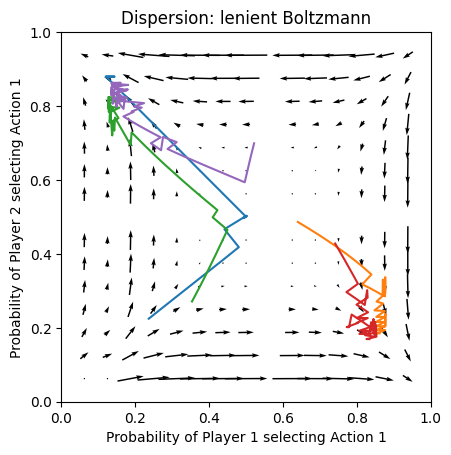

In [39]:
# Define the Dispersion game
payoff_matrix = np.array([[[-1, 1],
                     [1, -1]],
                     [[-1, 1],
                      [1, -1]]])

# Set up the replicator dynamics
dyn = LenientBoltzmannMultiQDynamics(payoff_matrix, lenient_boltzmann_dyn, 3)

# Create an object of the Dynamics2x2Axes class
fig, ax = plt.subplots(subplot_kw={'projection': visualization.Dynamics2x2Axes.name})
ax.set_xlabel('Probability of Player 1 selecting Action 1')
ax.set_ylabel('Probability of Player 2 selecting Action 1')
ax.set_title('Dispersion: lenient Boltzmann')

# Plot the directional field plot
ax.quiver(dyn, 15)

# Perform q-learning with epsilon greedy
Q_table = np.zeros((2, 2))
q_table, player1_policy, player2_policy = play_game(payoff_matrix, Q_table, 2, 2, 1000, 0.01, False, False)

print("Learned Q-values:")
print(q_table)

# Overlay multiple learning trajectories on the directional field plot
for i in range(5):
  Q_table = initialize_Q_table(2, 2, payoff_matrix)
  q_table, player1_policy, player2_policy = play_game(payoff_matrix, Q_table, 2, 2, 500, 0.1, False, False)
  trajectory_plot(ax, player1_policy, player2_policy)

## RPS: Epsilon greedy

Learned Q-values:
[[-9.16951200e-01  1.05428276e-03 -1.46078990e-01]
 [-1.16503270e+00  4.56947003e-04 -7.27405537e-01]]
[0.00042656275881750944, 0.0006314927866081227, 0.0008982612016197204, 0.001294946651091494, 0.0012931970065872547, 0.001708031944360922, 0.0021916145600344022, 0.002739738729438613, 0.003345489919053697, 0.003999850409888484, 0.004692415343101886, 0.005412121418122284, 0.006147909652136723, 0.006889270659211258, 0.007626648249823699, 0.008351699900453839, 0.009057428528035413, 0.009738208889957583, 0.016769856210271123, 0.01690486597251413, 0.017027120753455582, 0.01713775568424945, 0.017237818660291587, 0.01732827418528601, 0.017410007725063938, 0.017483830359966014, 0.01755048357329292, 0.017610644052769162, 0.017664928413653264, 0.017713897777383185, 0.017758062159607388, 0.018546381447580626, 0.0185074025972868, 0.01847237639164791, 0.018440897143069124, 0.01841260171807849, 0.028186556346835784, 0.027043719157361697, 0.026041069265563398, 0.025159995969147232, 

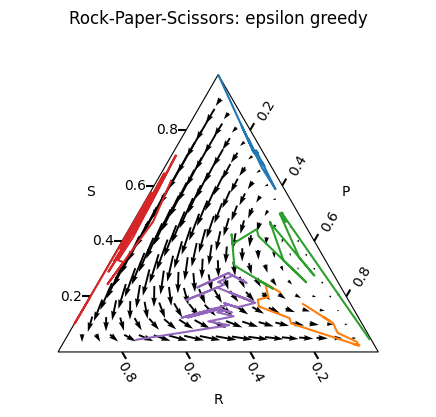

In [ ]:
# Define the RPS game
payoff_matrix = np.array([[[0, -2.5, 5],
                     [2.5, 0, -0.5],
                     [-5, 0.5, 0]],
                     [[0, 2.5, -5],
                      [-2.5, 0, 0.5],
                      [5, -0.5, 0]]])

# Set up the replicator dynamics
dyn = dynamics.SinglePopulationDynamics(payoff_matrix, dynamics.replicator)

# Plot the directional field plot
fig, ax = plt.subplots(subplot_kw={'projection': "3x3"})

# Add labels to the corner points
ax.text(0.5, -0.15, 'R', ha='center', va='center')
ax.text(0.1, 0.5, 'S', ha='center', va='center')
ax.text(0.9, 0.5, 'P', ha='center', va='center')
ax.set_title('Rock-Paper-Scissors: epsilon greedy')

ax.quiver(dyn)

# Perform q-learning with epsilon greedy
Q_table = np.zeros((2, 3))
q_table, rock, paper, scissors = play_game(payoff_matrix, Q_table, 3, 2, 1000, 0.1, True, True)

print("Learned Q-values:")
print(q_table)

# Overlay multiple learning trajectories on the directional field plot
for i in range(5):
  Q_table = initialize_Q_table(3, 2, payoff_matrix)
  q_table, rock, paper, scissors = play_game(payoff_matrix, Q_table, 3, 2, 100, 0.1, True, True)
  if i == 0:
    print(rock)
    print(paper)
    print(scissors)
  trajectory_plot_RPS(ax, rock, paper, scissors)
  

## RPS: Lenient Boltzmann

<ipython-input-41-96476ba48ab0>:156: RuntimeWarning: invalid value encountered in double_scalars
  u[j] = fitness[j] * (sum1 - sum2) / sum3


Learned Q-values:
[[-0.82993578 -0.48666713  0.29463674]
 [-1.009279   -0.30062482 -0.47436097]]
[0.9241131002137594, 0.8917057894329261, 0.8527217062689415, 0.8083232304823783, 0.7602206498382853, 0.7103642625514114, 0.6606274603819321, 0.6125718122328371, 0.5673323233968645, 0.5256103085274391, 0.49847410257978997, 0.4740414547053684, 0.45214490998669493, 0.4325856843970256, 0.41515327671764407, 0.3996384780402034, 0.38584141613423245, 0.35059459411778765, 0.33883153872586025, 0.32841027425478775, 0.3191718863174857, 0.3109758746044765, 0.30369854201338103, 0.29723126979836106, 0.29147881712779206, 0.28635772179548336, 0.34605859471167233, 0.3348136213142895, 0.3248491815475351, 0.3160133720204393, 0.3081721307252953, 0.3012075625581912, 0.29501621125843996, 0.2895073900652599, 0.2846016311115251, 0.2802292807257062, 0.2763292478993075, 0.27284790168355044, 0.26973810714534396, 0.2669583867052401, 0.2644721928715049, 0.3240817935815468, 0.38313006752539, 0.3676407761948145, 0.4248269

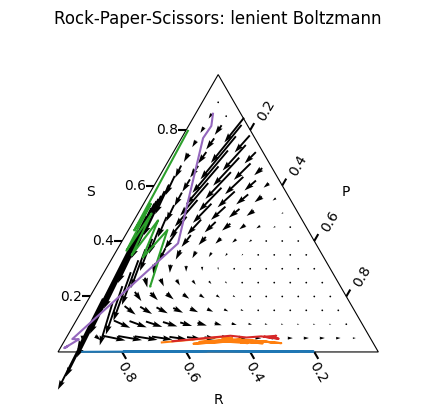

In [66]:
# Define the RPS game
payoff_matrix = np.array([[[0, -2.5, 5],
                     [2.5, 0, -0.5],
                     [-5, 0.5, 0]],
                     [[0, 2.5, -5],
                      [-2.5, 0, 0.5],
                      [5, -0.5, 0]]])

# Set up the replicator dynamics
dyn = LenientBoltzmannSingleQDynamics(payoff_matrix, lenient_boltzmann_dyn, 3)

# Plot the directional field plot
fig, ax = plt.subplots(subplot_kw={'projection': visualization.Dynamics3x3Axes.name})

# Add labels to the corner points
ax.text(0.5, -0.15, 'R', ha='center', va='center')
ax.text(0.1, 0.5, 'S', ha='center', va='center')
ax.text(0.9, 0.5, 'P', ha='center', va='center')
ax.set_title('Rock-Paper-Scissors: lenient Boltzmann')

ax.quiver(dyn)

# Perform q-learning with epsilon greedy
Q_table = np.zeros((2, 3))
q_table, rock, paper, scissors = play_game(payoff_matrix, Q_table, 3, 2, 1000, 0.1, False, True)

print("Learned Q-values:")
print(q_table)

# Overlay multiple learning trajectories on the directional field plot
for i in range(5):
  Q_table = initialize_Q_table(3, 2, payoff_matrix)
  q_table, rock, paper, scissors = play_game(payoff_matrix, Q_table, 3, 2, 100, 0.1, False, True)
  if i == 0:
    print(rock)
    print(paper)
    print(scissors)
  trajectory_plot_RPS(ax, rock, paper, scissors)